In [1]:
# imports
from torch.utils.data import Dataset, DataLoader, IterableDataset
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import torch
import pandas as pd
import json
import torchvision.transforms as transforms
import random
import torch.nn as nn
import torchvision
from tqdm import tqdm
import warnings


Uncomment line to download and extract dataset

In [2]:
# !wget -P ./root "https://cloud.dfki.de/owncloud/index.php/s/TwrjNFYpTCEdeKB/download"
# !unzip ./root/download
# !tar -xvzf "./AAI WS2022/bens2.tar.gz"


Uncomment line to create environment and install required depenancies

In [3]:
# conda env create -f environment.yml


In [4]:

BigEarthNetlabels = {
    "Urban fabric": 0,
    "Industrial or commercial units": 1,
    "Arable land": 2,
    "Permanent crops": 3,
    "Pastures": 4,
    "Complex cultivation patterns": 5,
    "Land principally occupied by agriculture, with significant areas of natural vegetation": 6,
    "Agro-forestry areas": 7,
    "Broad-leaved forest": 8,
    "Coniferous forest": 9,
    "Mixed forest": 10,
    "Natural grassland and sparsely vegetated areas": 11,
    "Moors, heathland and sclerophyllous vegetation": 12,
    "Transitional woodland, shrub": 13,
    "Beaches, dunes, sands": 14,
    "Inland wetlands": 15,
    "Coastal wetlands": 16,
    "Inland waters": 17,
    "Marine waters": 18
}

BigEarthNetLabelNames = {v: k for k, v in BigEarthNetlabels.items()}


Create Training, Validation and Test data sets 

In [5]:
def getFilePath(dirName, fileName):
    path = './netscratch/siddamsetty/kosovo_files/{}/{}_{}'.format(
        dirName, dirName, fileName)
    return path

# Merge RGB bands and return numpy image array


def getNumpyImageCv2(dirName):
    blue = cv2.imread(getFilePath(dirName, "B02.tif"),
                      cv2.IMREAD_UNCHANGED)
    blue = (blue-np.min(blue))/(np.max(blue)-np.min(blue))
    green = cv2.imread(getFilePath(
        dirName, "B03.tif"), cv2.IMREAD_UNCHANGED)
    green = (green-np.min(green))/(np.max(green)-np.min(green))
    red = cv2.imread(getFilePath(dirName, "B04.tif"),
                     cv2.IMREAD_UNCHANGED)
    red = (red-np.min(red))/(np.max(red)-np.min(red))
    return cv2.resize(cv2.merge([red, green, blue]), dsize=(224, 224))


def loadJson(dirName):
    path = './netscratch/siddamsetty/kosovo_files/{}/{}_labels_metadata.json'.format(
        dirName, dirName)
    with open(getFilePath(dirName, "labels_metadata.json")) as json_data:
        return json.load(json_data)


fileList = os.listdir(path='./netscratch/siddamsetty/kosovo_files/')

valSplit = int(np.floor(0.2*len(fileList)))
testSplit = valSplit
trainSplit = len(fileList) - valSplit - testSplit
train_set, val_set, test_set = torch.utils.data.random_split(
    fileList, [trainSplit, valSplit, testSplit])


def save(name, datset):
    if not os.path.exists("./data/"+name):
        os.makedirs("./data/"+name)
    lablesList = np.zeros(shape=(len(datset), 20), dtype=np.object_)
    for index, dirName in enumerate(datset):
        image = getNumpyImageCv2(dirName)*255
        # print(np.shape(image))
        cv2.imwrite("./data/"+name+"/"+dirName+'.jpg', image)
        labelMetadata = loadJson(dirName)
        labels = labelMetadata.get('labels')
        lablesList[index, 0] = dirName
        for label in labels:
            if BigEarthNetlabels.get(label) is not None:
                lablesList[index, BigEarthNetlabels.get(label)+1] = 1
    np.savetxt("./data/"+name+'/labels.csv',
               lablesList, delimiter=",", fmt="%s")


uncomment below lines to generate dataset again

In [6]:
# save("train",train_set)
# save("val",val_set)
# save("test",test_set)


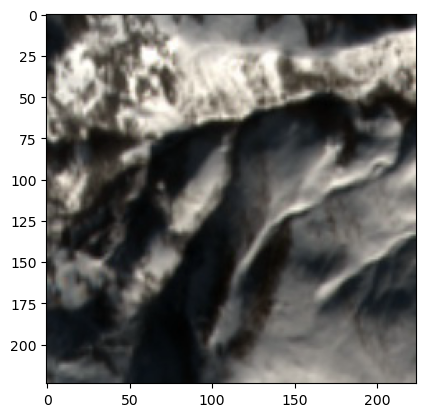

In [7]:
imageRead = cv2.imread("./data/test/S2A_MSIL2A_20171208T093351_0_22.jpg")
plt.imshow(imageRead)
plt.show()


Creating Dataset and Dataloader class for training

In [8]:
class BigEarthNetDataset(Dataset):

    def __init__(self, data_path, label_filename, transform=None, target_transform = None):
        self.fileList = os.listdir(path=data_path)
        labelPath = os.path.join(data_path, label_filename)
        self.img_labels = pd.read_csv(labelPath, header=None)
        self.data_path = data_path
        self.transform = transform

    def __len__(self):
        return len(self.img_labels.index)

    def __getitem__(self, index):
        imagePath = os.path.join(self.data_path,"{}.jpg".format(self.img_labels.iloc[index, 0]))
        image = cv2.imread(imagePath)
        labels = self.img_labels.iloc[index, 1:].to_numpy(dtype=np.float32)
        if self.transform:
            image = self.transform(image.astype(np.float32))
        labels = torch.tensor(labels)
        return image, labels

    def getName(self, index):
        return self.img_labels.iloc[index, 0]


In [9]:
print("Initializing Datasets and Dataloaders...")

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

valDataSet = BigEarthNetDataset(
    data_path='./data/val', label_filename="labels.csv", transform=transforms.ToTensor(),target_transform= train_transform)

trainDataSet = BigEarthNetDataset(
    data_path='./data/train', label_filename="labels.csv", transform=transforms.ToTensor(),target_transform= train_transform)

testDataSet = BigEarthNetDataset(
    data_path='./data/test', label_filename="labels.csv")   

dataloaders_dict = {"train": DataLoader(trainDataSet, batch_size=32, shuffle=True, num_workers=4), "val": DataLoader(
    valDataSet, batch_size=32, shuffle=True, num_workers=4), "test": DataLoader(testDataSet, batch_size=32, shuffle=True, num_workers=4)}


Initializing Datasets and Dataloaders...


Visualizing Random sample with labels

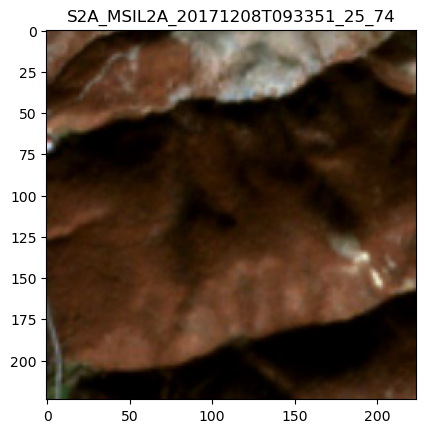

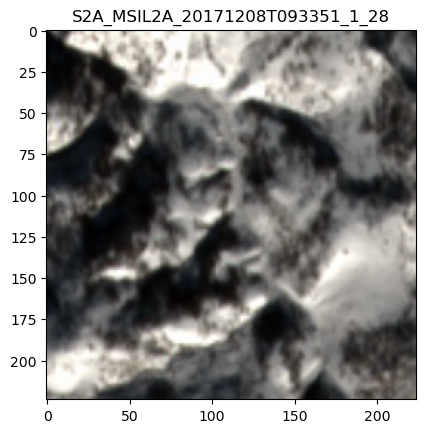

In [10]:

for index in random.sample(range(0, testDataSet.__len__()), 2):
    image, labels = testDataSet[index]
    plt.title(testDataSet.getName(index))
    plt.imshow(image)
    plt.show()

## todo: show lables along with image

In [11]:
device = torch.device("cpu")

In [12]:
# Use the torchvision's implementation of ResNeXt, but add FC layer for a different number of classes (19) and a Sigmoid instead of a default Softmax.


class Resnext50(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        resnet = torchvision.models.resnext50_32x4d(
            weights=torchvision.models.ResNeXt50_32X4D_Weights.DEFAULT)
        resnet.fc = torch.nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features,
                      out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))


# Initialize the model
model = Resnext50(len(BigEarthNetlabels))
# Switch model to the training mode
model.train()

Resnext50(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): 

In [13]:
criterion = torch.nn.BCELoss()

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Use threshold to define predicted labels and invoke sklearn's metrics with different averaging strategies.


def calculate_metrics(pred, target, threshold=0.5):
    pred = np.array(pred > threshold, dtype=float)
    return {'micro/precision': precision_score(y_true=target, y_pred=pred, average='micro'),
            'micro/recall': recall_score(y_true=target, y_pred=pred, average='micro'),
            'micro/f1': f1_score(y_true=target, y_pred=pred, average='micro'),
            'macro/precision': precision_score(y_true=target, y_pred=pred, average='macro'),
            'macro/recall': recall_score(y_true=target, y_pred=pred, average='macro'),
            'macro/f1': f1_score(y_true=target, y_pred=pred, average='macro'),
            'samples/precision': precision_score(y_true=target, y_pred=pred, average='samples'),
            'samples/recall': recall_score(y_true=target, y_pred=pred, average='samples'),
            'samples/f1': f1_score(y_true=target, y_pred=pred, average='samples'),
            }

In [15]:
batch_size = 32
max_epoch_number = 13
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
import numpy as np
import torch


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, verbose=False, delta=0, path='..//masters//save_model//checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_acc_max = 0
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_acc, model):

        score = val_acc
        print(f'score is {score} and val_loss is {val_acc}')
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_acc, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(
                f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_acc, model)
            self.counter = 0

    def save_checkpoint(self, val_acc, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(
                f'Validation acc increased ({self.val_acc_max:.6f} --> {val_acc:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_acc_max = val_acc


In [17]:
model.load_state_dict(torch.load("checkpoint.pt"))
model.eval()
model.train()

Resnext50(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): 

In [18]:
warnings.filterwarnings('ignore')

epoch = 0
iteration = 0
test_freq = 7
save_freq = 1

resultF1 = 0
early_stopping = EarlyStopping(verbose=True, path="checkpoint.pt")


while True:
    batch_losses = []
    for index,imgsAndTargets in enumerate(tqdm(dataloaders_dict.get("train"))):
        imgs ,targets = imgsAndTargets
        imgs, targets = imgs.to(device), targets.to(device)

        optimizer.zero_grad()

        model_result = model(imgs)
        loss = criterion(model_result, targets)

        batch_loss_value = loss.item()
        loss.backward()
        optimizer.step()

        batch_losses.append(batch_loss_value)

        if iteration % test_freq == 0:
            model.eval()
            with torch.no_grad():
                model_result = []
                targets = []
                for index,imgsAndBatchTargets in enumerate(tqdm(dataloaders_dict.get("val"))):
                    imgs, batch_targets = imgsAndBatchTargets
                    imgs = imgs.to(device)
                    model_batch_result = model(imgs)
                    model_result.extend(model_batch_result.cpu().numpy())
                    targets.extend(batch_targets.cpu().numpy())

            result = calculate_metrics(
                np.array(model_result), np.array(targets))
            resultF1 = result.get("macro/f1")
            print("epoch:{:2d} iter:{:3d} test: "
                  "micro f1: {:.3f} "
                  "macro f1: {:.3f} "
                  "samples f1: {:.3f}".format(epoch, iteration,
                                              result['micro/f1'],
                                              result['macro/f1'],
                                              result['samples/f1']))

            model.train()
        iteration += 1

    loss_value = np.mean(batch_losses)
    print("epoch:{:2d} iter:{:3d} train: loss:{:.3f}".format(
        epoch, iteration, loss_value))
    early_stopping(resultF1, model)
    if early_stopping.early_stop:
        break
    epoch += 1
    if max_epoch_number < epoch:
        break


  2%|▏         | 1/46 [00:33<25:13, 33.64s/it]

epoch: 0 iter:  0 test: micro f1: 0.711 macro f1: 0.178 samples f1: 0.648


 17%|█▋        | 8/46 [01:26<07:40, 12.13s/it]

epoch: 0 iter:  7 test: micro f1: 0.654 macro f1: 0.151 samples f1: 0.566


 33%|███▎      | 15/46 [02:18<05:55, 11.47s/it]

epoch: 0 iter: 14 test: micro f1: 0.694 macro f1: 0.165 samples f1: 0.623


 48%|████▊     | 22/46 [03:10<04:33, 11.41s/it]

epoch: 0 iter: 21 test: micro f1: 0.708 macro f1: 0.185 samples f1: 0.627


 63%|██████▎   | 29/46 [04:03<03:15, 11.52s/it]

epoch: 0 iter: 28 test: micro f1: 0.715 macro f1: 0.172 samples f1: 0.645


 78%|███████▊  | 36/46 [04:55<01:53, 11.38s/it]

epoch: 0 iter: 35 test: micro f1: 0.688 macro f1: 0.172 samples f1: 0.591


 93%|█████████▎| 43/46 [05:47<00:34, 11.41s/it]

epoch: 0 iter: 42 test: micro f1: 0.715 macro f1: 0.184 samples f1: 0.626


100%|██████████| 46/46 [05:58<00:00,  7.78s/it]


epoch: 0 iter: 46 train: loss:0.041
score is 0.1841596196185557 and val_loss is 0.1841596196185557
Validation acc increased (0.000000 --> 0.184160).  Saving model ...


  9%|▊         | 4/46 [00:40<09:09, 13.08s/it]

epoch: 1 iter: 49 test: micro f1: 0.710 macro f1: 0.163 samples f1: 0.606


 24%|██▍       | 11/46 [01:31<06:41, 11.47s/it]

epoch: 1 iter: 56 test: micro f1: 0.734 macro f1: 0.175 samples f1: 0.640


 39%|███▉      | 18/46 [02:23<05:19, 11.40s/it]

epoch: 1 iter: 63 test: micro f1: 0.718 macro f1: 0.178 samples f1: 0.635


 54%|█████▍    | 25/46 [03:16<04:02, 11.57s/it]

epoch: 1 iter: 70 test: micro f1: 0.679 macro f1: 0.172 samples f1: 0.602


 70%|██████▉   | 32/46 [04:07<02:38, 11.32s/it]

epoch: 1 iter: 77 test: micro f1: 0.677 macro f1: 0.177 samples f1: 0.617


 85%|████████▍ | 39/46 [04:59<01:19, 11.40s/it]

epoch: 1 iter: 84 test: micro f1: 0.726 macro f1: 0.192 samples f1: 0.644


100%|██████████| 46/46 [05:49<00:00, 10.81s/it]

epoch: 1 iter: 91 test: micro f1: 0.737 macro f1: 0.209 samples f1: 0.635


100%|██████████| 46/46 [05:50<00:00,  7.61s/it]


epoch: 1 iter: 92 train: loss:0.027
score is 0.20934922059862712 and val_loss is 0.20934922059862712
Validation acc increased (0.184160 --> 0.209349).  Saving model ...


 15%|█▌        | 7/46 [00:53<07:21, 11.32s/it]

epoch: 2 iter: 98 test: micro f1: 0.706 macro f1: 0.211 samples f1: 0.605


 30%|███       | 14/46 [01:44<06:00, 11.28s/it]

epoch: 2 iter:105 test: micro f1: 0.713 macro f1: 0.207 samples f1: 0.617


 46%|████▌     | 21/46 [02:35<04:43, 11.35s/it]

epoch: 2 iter:112 test: micro f1: 0.711 macro f1: 0.177 samples f1: 0.608


 61%|██████    | 28/46 [03:26<03:19, 11.08s/it]

epoch: 2 iter:119 test: micro f1: 0.738 macro f1: 0.177 samples f1: 0.648


 76%|███████▌  | 35/46 [04:16<02:01, 11.04s/it]

epoch: 2 iter:126 test: micro f1: 0.736 macro f1: 0.187 samples f1: 0.650


 91%|█████████▏| 42/46 [05:08<00:44, 11.15s/it]

epoch: 2 iter:133 test: micro f1: 0.744 macro f1: 0.191 samples f1: 0.669


100%|██████████| 46/46 [05:23<00:00,  7.03s/it]


epoch: 2 iter:138 train: loss:0.019
score is 0.19123867046702625 and val_loss is 0.19123867046702625
EarlyStopping counter: 1 out of 7


  7%|▋         | 3/46 [00:35<10:14, 14.28s/it]

epoch: 3 iter:140 test: micro f1: 0.733 macro f1: 0.207 samples f1: 0.631


 22%|██▏       | 10/46 [01:25<06:45, 11.27s/it]

epoch: 3 iter:147 test: micro f1: 0.740 macro f1: 0.206 samples f1: 0.657


 37%|███▋      | 17/46 [02:16<05:22, 11.13s/it]

epoch: 3 iter:154 test: micro f1: 0.739 macro f1: 0.199 samples f1: 0.658


 52%|█████▏    | 24/46 [03:06<04:03, 11.09s/it]

epoch: 3 iter:161 test: micro f1: 0.709 macro f1: 0.196 samples f1: 0.619


 67%|██████▋   | 31/46 [03:57<02:47, 11.19s/it]

epoch: 3 iter:168 test: micro f1: 0.693 macro f1: 0.183 samples f1: 0.604


 83%|████████▎ | 38/46 [04:48<01:29, 11.20s/it]

epoch: 3 iter:175 test: micro f1: 0.713 macro f1: 0.196 samples f1: 0.643


 98%|█████████▊| 45/46 [05:39<00:11, 11.29s/it]

epoch: 3 iter:182 test: micro f1: 0.681 macro f1: 0.175 samples f1: 0.591


100%|██████████| 46/46 [05:42<00:00,  7.44s/it]


epoch: 3 iter:184 train: loss:0.016
score is 0.17532708873225583 and val_loss is 0.17532708873225583
EarlyStopping counter: 2 out of 7


 13%|█▎        | 6/46 [00:48<07:40, 11.52s/it]

epoch: 4 iter:189 test: micro f1: 0.680 macro f1: 0.152 samples f1: 0.610


 28%|██▊       | 13/46 [01:39<06:09, 11.21s/it]

epoch: 4 iter:196 test: micro f1: 0.686 macro f1: 0.160 samples f1: 0.647


 43%|████▎     | 20/46 [02:30<04:49, 11.15s/it]

epoch: 4 iter:203 test: micro f1: 0.656 macro f1: 0.151 samples f1: 0.607


 59%|█████▊    | 27/46 [03:20<03:30, 11.08s/it]

epoch: 4 iter:210 test: micro f1: 0.732 macro f1: 0.180 samples f1: 0.648


 74%|███████▍  | 34/46 [04:11<02:14, 11.20s/it]

epoch: 4 iter:217 test: micro f1: 0.726 macro f1: 0.166 samples f1: 0.648


 89%|████████▉ | 41/46 [05:02<00:55, 11.16s/it]

epoch: 4 iter:224 test: micro f1: 0.707 macro f1: 0.187 samples f1: 0.632


100%|██████████| 46/46 [05:22<00:00,  7.02s/it]


epoch: 4 iter:230 train: loss:0.025
score is 0.1873540554838684 and val_loss is 0.1873540554838684
EarlyStopping counter: 3 out of 7


  4%|▍         | 2/46 [00:30<12:27, 16.99s/it]

epoch: 5 iter:231 test: micro f1: 0.669 macro f1: 0.187 samples f1: 0.586


 20%|█▉        | 9/46 [01:21<07:04, 11.48s/it]

epoch: 5 iter:238 test: micro f1: 0.677 macro f1: 0.186 samples f1: 0.590


 35%|███▍      | 16/46 [02:12<05:36, 11.20s/it]

epoch: 5 iter:245 test: micro f1: 0.714 macro f1: 0.177 samples f1: 0.629


 50%|█████     | 23/46 [03:03<04:17, 11.19s/it]

epoch: 5 iter:252 test: micro f1: 0.724 macro f1: 0.191 samples f1: 0.631


 65%|██████▌   | 30/46 [03:55<03:03, 11.45s/it]

epoch: 5 iter:259 test: micro f1: 0.721 macro f1: 0.188 samples f1: 0.618


 80%|████████  | 37/46 [04:46<01:41, 11.26s/it]

epoch: 5 iter:266 test: micro f1: 0.728 macro f1: 0.201 samples f1: 0.632


 96%|█████████▌| 44/46 [05:37<00:22, 11.10s/it]

epoch: 5 iter:273 test: micro f1: 0.721 macro f1: 0.201 samples f1: 0.647


100%|██████████| 46/46 [05:44<00:00,  7.49s/it]


epoch: 5 iter:276 train: loss:0.015
score is 0.2005990937876558 and val_loss is 0.2005990937876558
EarlyStopping counter: 4 out of 7


 11%|█         | 5/46 [00:43<08:11, 11.99s/it]

epoch: 6 iter:280 test: micro f1: 0.717 macro f1: 0.179 samples f1: 0.620


 26%|██▌       | 12/46 [01:34<06:25, 11.35s/it]

epoch: 6 iter:287 test: micro f1: 0.732 macro f1: 0.189 samples f1: 0.644


 41%|████▏     | 19/46 [02:26<05:08, 11.43s/it]

epoch: 6 iter:294 test: micro f1: 0.752 macro f1: 0.196 samples f1: 0.658


 57%|█████▋    | 26/46 [03:18<03:50, 11.52s/it]

epoch: 6 iter:301 test: micro f1: 0.748 macro f1: 0.195 samples f1: 0.661


 72%|███████▏  | 33/46 [04:11<02:30, 11.55s/it]

epoch: 6 iter:308 test: micro f1: 0.762 macro f1: 0.202 samples f1: 0.671


 87%|████████▋ | 40/46 [05:02<01:08, 11.42s/it]

epoch: 6 iter:315 test: micro f1: 0.701 macro f1: 0.183 samples f1: 0.597


100%|██████████| 46/46 [05:26<00:00,  7.09s/it]


epoch: 6 iter:322 train: loss:0.011
score is 0.18255257156068855 and val_loss is 0.18255257156068855
EarlyStopping counter: 5 out of 7


  2%|▏         | 1/46 [00:26<19:46, 26.36s/it]

epoch: 7 iter:322 test: micro f1: 0.627 macro f1: 0.159 samples f1: 0.561


 17%|█▋        | 8/46 [01:17<07:16, 11.49s/it]

epoch: 7 iter:329 test: micro f1: 0.701 macro f1: 0.187 samples f1: 0.624


 33%|███▎      | 15/46 [02:07<05:45, 11.13s/it]

epoch: 7 iter:336 test: micro f1: 0.717 macro f1: 0.186 samples f1: 0.610


 48%|████▊     | 22/46 [02:58<04:25, 11.07s/it]

epoch: 7 iter:343 test: micro f1: 0.733 macro f1: 0.202 samples f1: 0.629


 63%|██████▎   | 29/46 [03:49<03:09, 11.14s/it]

epoch: 7 iter:350 test: micro f1: 0.735 macro f1: 0.208 samples f1: 0.651


 78%|███████▊  | 36/46 [04:40<01:52, 11.20s/it]

epoch: 7 iter:357 test: micro f1: 0.727 macro f1: 0.212 samples f1: 0.647


 93%|█████████▎| 43/46 [05:31<00:33, 11.21s/it]

epoch: 7 iter:364 test: micro f1: 0.712 macro f1: 0.203 samples f1: 0.633


100%|██████████| 46/46 [05:42<00:00,  7.45s/it]


epoch: 7 iter:368 train: loss:0.009
score is 0.20250064658406003 and val_loss is 0.20250064658406003
EarlyStopping counter: 6 out of 7


  9%|▊         | 4/46 [00:39<08:55, 12.75s/it]

epoch: 8 iter:371 test: micro f1: 0.714 macro f1: 0.198 samples f1: 0.634


 24%|██▍       | 11/46 [01:30<06:34, 11.28s/it]

epoch: 8 iter:378 test: micro f1: 0.728 macro f1: 0.202 samples f1: 0.647


 39%|███▉      | 18/46 [02:22<05:20, 11.45s/it]

epoch: 8 iter:385 test: micro f1: 0.743 macro f1: 0.204 samples f1: 0.661


 54%|█████▍    | 25/46 [03:13<03:55, 11.22s/it]

epoch: 8 iter:392 test: micro f1: 0.754 macro f1: 0.204 samples f1: 0.663


 70%|██████▉   | 32/46 [04:04<02:35, 11.13s/it]

epoch: 8 iter:399 test: micro f1: 0.752 macro f1: 0.199 samples f1: 0.660


 85%|████████▍ | 39/46 [04:56<01:19, 11.30s/it]

epoch: 8 iter:406 test: micro f1: 0.739 macro f1: 0.203 samples f1: 0.652


100%|██████████| 46/46 [05:44<00:00, 10.55s/it]

epoch: 8 iter:413 test: micro f1: 0.730 macro f1: 0.197 samples f1: 0.650


100%|██████████| 46/46 [05:44<00:00,  7.50s/it]

epoch: 8 iter:414 train: loss:0.007
score is 0.19667023917619939 and val_loss is 0.19667023917619939
EarlyStopping counter: 7 out of 7
